In [1]:
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import EasyEnsembleClassifier, RUSBoostClassifier
from sklearn.decomposition import PCA
import scipy.io as spio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
folder = "/n/holylfs02/LABS/olveczky_lab/Everyone/Ephys2_example/hand_labeled_clusters"

def loadmat(filename):
    """
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    """
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)


def _check_keys(dict):
    """
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    """
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict


def _todict(matobj):
    """
    A recursive function which constructs from matobjects nested dictionaries
    """
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict


def load_data(folder):
    files = [os.path.join(folder, f) for f in os.listdir(folder)]
    waveforms = []
    labels = []
    for file in files:
        M = loadmat(file)
        
        good_waveforms = M["good_waveforms"]
        good_waveform_nan_inds = np.any(np.isnan(good_waveforms), axis=1)
        good_waveforms = good_waveforms[~good_waveform_nan_inds,:]
        
        bad_waveforms = M["bad_waveforms"]
        bad_waveform_nan_inds = np.any(np.isnan(bad_waveforms), axis=1)
        bad_waveforms = bad_waveforms[~bad_waveform_nan_inds,:]\

        
        waveforms.append(good_waveforms)
        waveforms.append(bad_waveforms)
        labels.append(np.ones(np.sum(~good_waveform_nan_inds),))
        labels.append(np.zeros((np.sum(~bad_waveform_nan_inds),)))    
    X = np.concatenate(waveforms, axis=0)
    return X, np.concatenate(labels, axis=0)
        
X, y = load_data(folder)
pca = PCA(n_components=10, whiten=True)
X = pca.fit_transform(X)

/tmp/ipykernel_137859/1995516425.py:20: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):


In [11]:
print(X.shape)

(1513, 10)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8675309)

In [4]:

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''

    dfs = []
    models = [
              ('LogReg', LogisticRegression(max_iter=200)), 
              ('RF', RandomForestClassifier()),
              ('KNN', KNeighborsClassifier()),
              ('SVM', SVC()), 
              ('GNB', GaussianNB()),
              ('XGB', XGBClassifier()),
              ('RUS', RUSBoostClassifier()),
            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['malignant', 'benign']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final
final = run_exps(X_train, y_train, X_test, y_test)


LogReg
              precision    recall  f1-score   support

   malignant       0.85      0.91      0.88       209
      benign       0.88      0.81      0.84       170

    accuracy                           0.86       379
   macro avg       0.87      0.86      0.86       379
weighted avg       0.86      0.86      0.86       379

RF
              precision    recall  f1-score   support

   malignant       0.93      0.94      0.94       209
      benign       0.93      0.92      0.92       170

    accuracy                           0.93       379
   macro avg       0.93      0.93      0.93       379
weighted avg       0.93      0.93      0.93       379

KNN
              precision    recall  f1-score   support

   malignant       0.92      0.92      0.92       209
      benign       0.91      0.90      0.90       170

    accuracy                           0.91       379
   macro avg       0.91      0.91      0.91       379
weighted avg       0.91      0.91      0.91       379

SVM
 

In [5]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

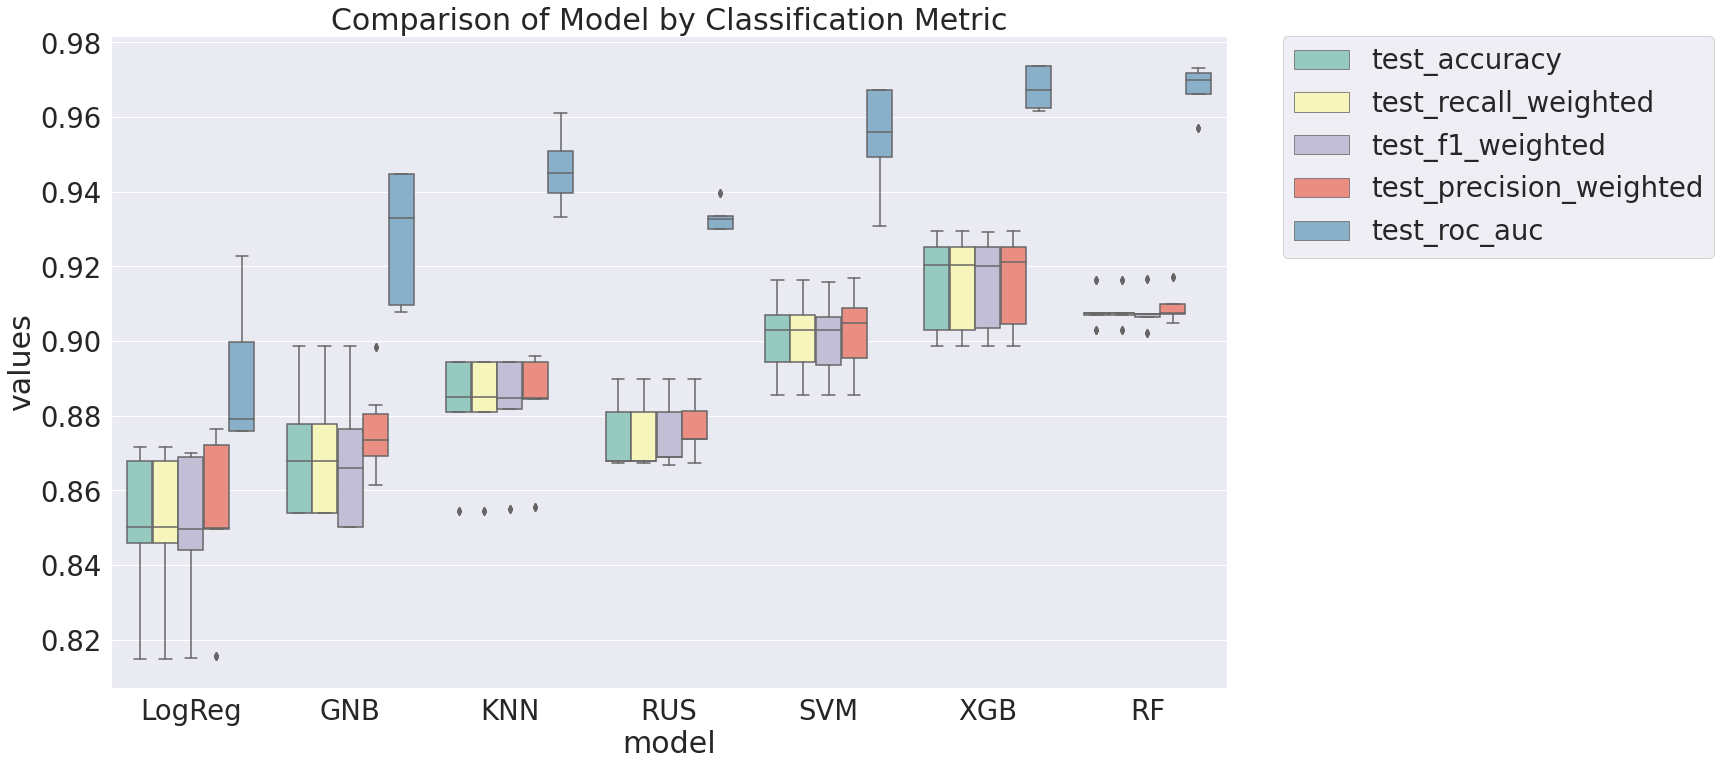

In [6]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

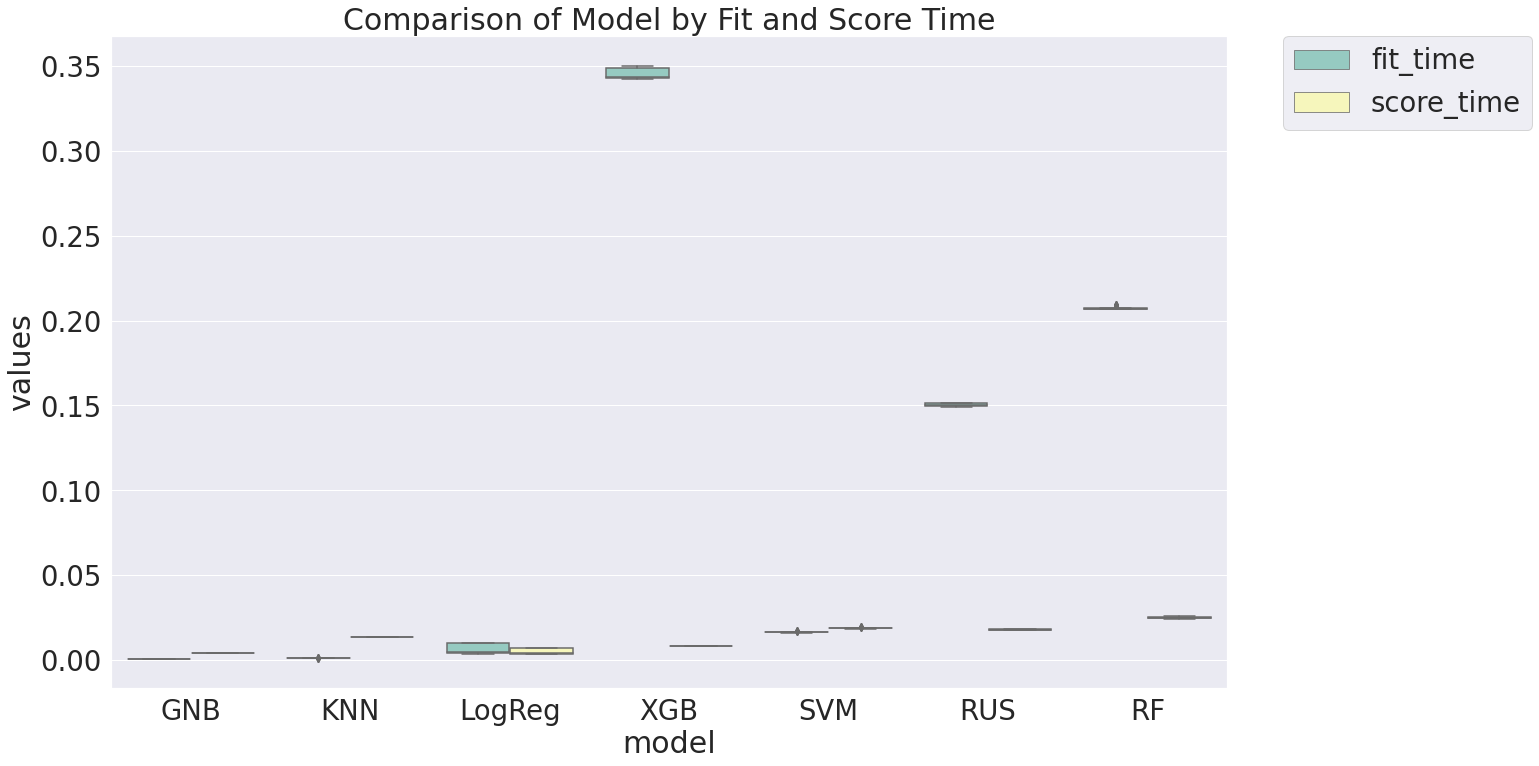

In [7]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [8]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

score_time            fit_time          
              std      mean       std      mean
model                                          
GNB      0.000052  0.004053  0.000021  0.000904
KNN      0.000109  0.013504  0.000086  0.001071
LogReg   0.001638  0.005066  0.002709  0.006259
RF       0.000733  0.025138  0.001059  0.207506
RUS      0.000090  0.018016  0.000685  0.150302
SVM      0.000367  0.018981  0.000443  0.016623
XGB      0.000115  0.008395  0.003316  0.345741

# Train a final model and PCA, save it, load it, and predict with it

In [9]:
model = XGBClassifier()
model.fit(X,y)
with open("classifier.p", "wb") as file:
    pickle.dump({"model": model, "pca": pca}, file)
with open("classifier.p", "rb") as file:
    in_dict = pickle.load(file)
model = in_dict["model"]
y_pred = model.predict(X)